<a href="https://colab.research.google.com/github/markertassel/fantasypublic/blob/main/Another_copy_of_NBA_Regression_to_the_Mean_in_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
devtools::install_github(repo = "maksimhorowitz/nflscrapR")
library(nflscrapR)

In [ ]:
install.packages("ggplot2")
library(ggplot2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
data <- read.csv("NBA_Player_Stats.csv")
data <- data[, c("Player","G", "Year","X3P","X3PA","X3P.")]
data <- data[data$"Year" == "2021-2022" ,]
data <- data |>                                                                                   #
  dplyr::mutate(total_threes_attempted = round(X3PA * G))
data <- data |>                                                                                   #
  dplyr::mutate(total_threes_made = round(X3P * G))
data <- data[, c("Player", "total_threes_attempted","total_threes_made","X3P.")]
data <- data[data$total_threes_attempted > 100, ]

In [ ]:
league_threes_rate <- data |>                                                                    #
  dplyr::summarize(rate = sum(total_threes_made) / sum(total_threes_attempted)) |>                      #
  with(rate)

In [ ]:
data <- data |>                                                                                   #
  dplyr::mutate(                                                                                  #
    noise_variance = league_threes_rate * (1 - league_threes_rate) / total_threes_attempted           #
  )                                                                                               #

In [ ]:
#' Estimate population variance                                                                   #
#'                                                                                                #
#' Estimate the population variance in true talent for a performance metric given a vector of     #
#' observed values and associated noise variances.                                                #
#'                                                                                                #
#' @param observed_value vector of observed performance                                           #
#' @param noise_variance vector of estimated noise variance                                       #
#' @param population_mean scalar, population mean for `observed_value`                            #
#' @param max_iterations integer, optimization stops after `max_iterations` is reached            #
#' @param tolerance scalar, optimization stops after movement in estimated population variance is #
#'   less than tolerance                                                                          #
#'                                                                                                #
#' @return a scalar estimate of population variance                                               #
#'                                                                                                #
estimate_population_variance <- function(observed_value,                                          #
                                         noise_variance,                                          #
                                         population_mean = weighted.mean(observed_value,          #
                                           w = 1 / noise_variance,                                #
                                           na.rm = TRUE                                           #
                                         ),                                                       #
                                         max_iterations = 1e4,                                    #
                                         tolerance = 1e-7 * var(observed_value)) {                #

  point_estimate <- (observed_value - population_mean)^2 - noise_variance                         #
  last_population_variance <- 0                                                                   #
  population_variance <- mean((observed_value - population_mean)^2)                               #

  t <- 0                                                                                          #
  while(abs(population_variance - last_population_variance) > tolerance & t < max_iterations) {   #

    t <- t + 1                                                                                    #
    last_population_variance <- population_variance                                               #
    weight <- (noise_variance + population_variance)^{-2}                                         #
    population_variance <- weighted.mean(point_estimate, w = weight)                              #
  }                                                                                               #

  return(population_variance)                                                                     #
}
population_variance                                                                                            #

[1] 0.0006117045

In [ ]:
population_variance <- data |>                                                                    #
  dplyr::filter(total_threes_attempted > 30) |>                                                         #
  with(                                                                                           #
    estimate_population_variance(                                                                 #
      observed_value = X3P.,                                                              #
      noise_variance = noise_variance,                                                            #
      population_mean = league_threes_rate                                                    #
    )                                                                                             #
  )
  population_variance

[1] 0.0006117045

In [ ]:
data <- data |>                                                                                   #
  dplyr::mutate(                                                                                  #
    regressed_three_rate = (                                                                    #
      X3P. / noise_variance + league_threes_rate / population_variance                   #
    ) / (                                                                                         #
      1 / noise_variance + 1 / population_variance                                                #
    )                                                                                             #
  )

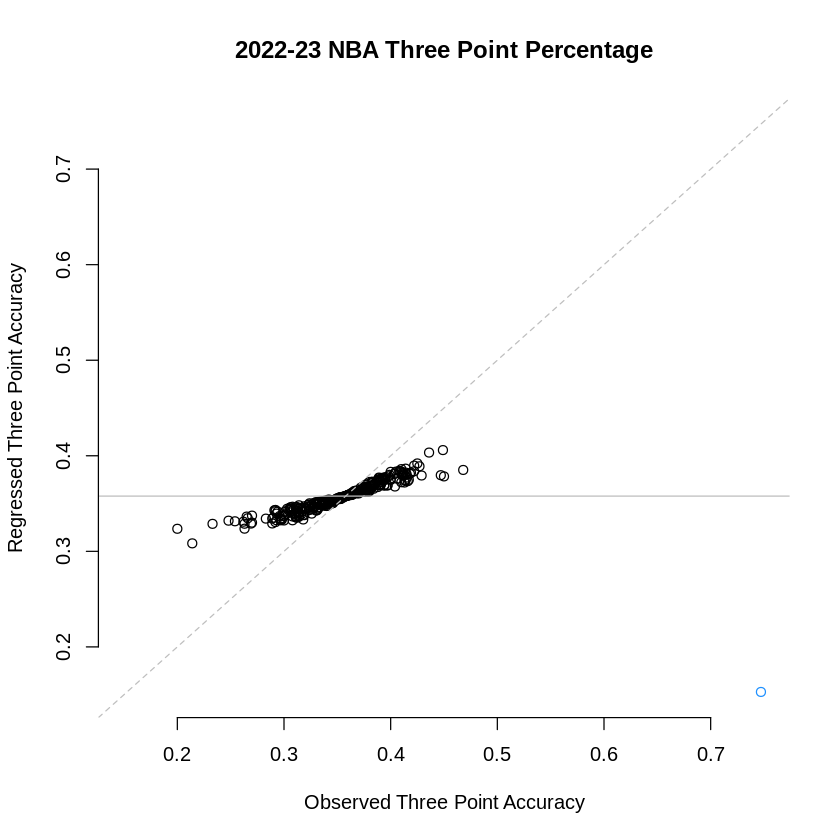

In [ ]:
with(data,                                                                                        #
  plot(                                                                                           #
    x = X3P.,                                                                             #
    y = regressed_three_rate,                                                                   #
    xlim = c(0.15, 0.75),                                                                         #
    ylim = c(0.15, 0.75),                                                                         #
    main = "2022-23 NBA Three Point Percentage",                                                   #
    xlab = "Observed Three Point Accuracy",                                                               #
    ylab = "Regressed Three Point Accuracy",                                                              #,                                   #
    axes = FALSE    # add the x- and y-axis later (aesthetic preference)                          #
  )                                                                                               #
)                                                                                                 #

abline(0, 1, lty = 2, col = "gray")             # add a dashed diagonal like y = x for reference  #
abline(h = league_threes_rate, col = "gray")   # add a horizontal line at the league average     #
axis(1)                                         # add an x-axis                                   #
axis(2)                                         # add a y-axis                                    #

legend("bottomright",                                                                             #
  legend = c(""),                                                   #
  col = c("dodgerblue", "black"),                                                                 #
  pch = 1,                                                                                        #
  bty = "n"                                                                                       #
)                                                                                    #

In [ ]:
ggplot(df, aes(x = "X3P." , y = "regressed_three_rate")) +
  geom_line(color = "blue", size = 2) +
  labs(x = "Observed Three Point Accuracy", y = "Regressed Three Point Accuracy", title = "2022-23 NBA Three Point Percentage")

In [ ]:
data |>                                                                                           #
  dplyr::arrange(-regressed_three_rate) |>                                                                #
  head(20)